In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pizza-not-pizza/pizza_not_pizza/food101_subset.py
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2374305.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2415437.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/1123352.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2294128.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/215349.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/938244.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/444123.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/884964.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2394770.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/901984.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/117282.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/1227349.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/1743531.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/21

### Import Libaries and Dependencies


In [2]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import pandas

### Load Dataset


In [3]:
train_dir = '/kaggle/input/pizza-not-pizza/pizza_not_pizza/'

In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=32,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 1966 files belonging to 2 classes.
Using 1573 files for training.


2022-08-16 14:50:50.065364: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 14:50:50.177841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 14:50:50.178599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 14:50:50.181790: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
val_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=32,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 1966 files belonging to 2 classes.
Using 393 files for validation.


In [6]:
class_names = train_data.class_names
print(class_names)

['not_pizza', 'pizza']


### Visualise the Data

2022-08-16 14:50:53.177914: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


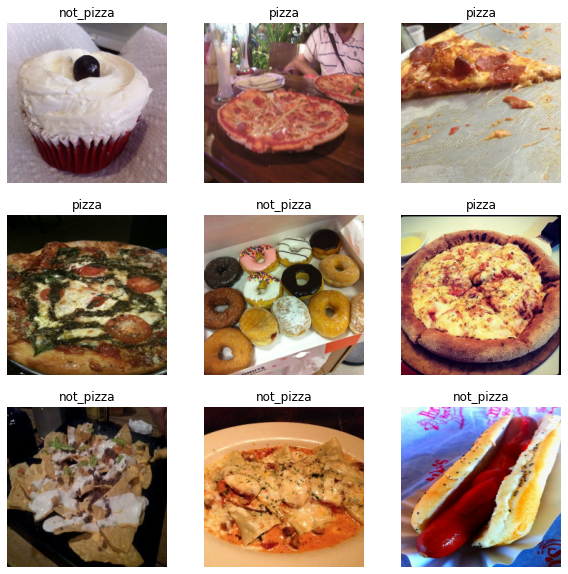

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("int32"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [9]:
###Configure Dataset for Better Performance
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

### Standardized Dataset

In [10]:
normalization_layer = keras.layers.Rescaling(1./255)
num_classes = len(class_names)
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)


In [11]:
base = tf.keras.applications.resnet50.ResNet50(include_top=False,input_shape=IMG_SHAPE)
base.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


### Feature Extractor Layer

In [12]:
base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Build Model

In [13]:
data_augmentation = tf.keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical"),
  keras.layers.RandomRotation(0.2),

])

In [14]:
input_layer = keras.layers.Input(shape =IMG_SHAPE)
input_layer.shape
x = normalization_layer(input_layer)
x = data_augmentation(x)
x = base(input_layer)
x = keras.layers.GlobalAveragePooling2D()(x)
x.shape
x = keras.layers.Dense(256, activation ='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(input_layer, outputs)


In [15]:

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 24,112,770
Trainable params: 525,058
Non-trainable params: 23,587,712
___________________________________________

In [16]:
history = model.fit(train_data,
                    epochs=5,
                    validation_data=val_data)

Epoch 1/5


2022-08-16 14:51:08.117414: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


50/50 [==============================] - 21s 122ms/step - loss: 0.5082 - accuracy: 0.8195 - val_loss: 0.2572 - val_accuracy: 0.9109
Epoch 2/5
50/50 [==============================] - 3s 68ms/step - loss: 0.1686 - accuracy: 0.9326 - val_loss: 0.2309 - val_accuracy: 0.9059
Epoch 3/5
50/50 [==============================] - 3s 70ms/step - loss: 0.1330 - accuracy: 0.9523 - val_loss: 0.2308 - val_accuracy: 0.9135
Epoch 4/5
50/50 [==============================] - 3s 70ms/step - loss: 0.0903 - accuracy: 0.9663 - val_loss: 0.2508 - val_accuracy: 0.9033
Epoch 5/5
50/50 [==============================] - 3s 69ms/step - loss: 0.0670 - accuracy: 0.9765 - val_loss: 0.2964 - val_accuracy: 0.9008
